This document is number `4 of 5` documents I have written, based on the `LangChain Academy Deep Agents with LangGraph` course.

The course itself has repositories that it provides you with. If my documents are not useful to you, I suggest you check them out.

There are now several successful examples of very **capable** and **long-running** agents. They have given these agents the 
name `“Deep Agents”` because they believe that they are completely different from previous generations of agents. In 
this course, you will learn what makes them different and build your own Deep Agent.

In LangChain, a Deep Agent is built that is simple and configurable, allowing users to build long-running agents quickly and easily.

In this course, you will build a **Deep Research Agent** using Deep Agent. The course is divided into seven modules.

Each module includes a video lesson that introduces you to the key concepts, along with related workbooks.

---



This repository shows how to keep AI agents focused by delegating work to specialized sub-agents that each run in their own clean context. If you’ve ever seen an agent “lose the plot” during long tasks, sub-agents are the remedy: they isolate context, avoid clashes, and keep each task crisp and on-track.

---

### Why Sub-Agents?

- **Problem:** As conversations grow, a single agent’s context fills up with multiple goals, partial results, and side threads. This causes:
  - Context clashes (mixed objectives)
  - Confusion and dilution (forgetting what matters)
  - “Poisoning” (irrelevant info affects new tasks)

- **Solution:** Context isolation via sub-agents.
  - Create smaller, specialized agents for specific tasks (e.g., “research-agent”).
  - Each sub-agent runs with a clean context limited to its task description.
  - The main (supervisor) agent delegates work and receives only the results.

---

### What You’ll Build

- A supervisor agent that can:
  - See which sub-agents are available
  - Use a `task(...)` tool to delegate a task to a chosen sub-agent
  - Receive the sub-agent’s answer as a tool result (cleanly merged back)

- A sub-agent:
  - Given a purpose-specific prompt
  - Given only the tools it needs (e.g., `web_search`)
  - Runs with only the task description in its context

---

### Imports

In [ ]:
from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.messages import ToolMessage, HumanMessage, AIMessage
from langchain_core.tools import InjectedToolCallId, tool, BaseTool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent


### 1) Sub-agent configuration (TypedDict)

A sub-agent is defined by a simple schema:

In [2]:
class SubAgent(TypedDict):
    name: str                 # Unique key (e.g., "research-agent")
    description: str          # What it does (shown to the supervisor)
    prompt: str               # How it should behave internally
    tools: NotRequired[list[str]]  # Which tools it can use (by name)

In [3]:
def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence."""
    if left is None:
        return right
    elif right is None:
        return left
    else:
        # New values overwrite old ones
        return {**left, **right}

class DeepAgentState(AgentState):
    """Extended agent state with todos and a virtual filesystem."""
    files: Annotated[NotRequired[dict[str, str]], file_reducer]


- You’ll pass a list of `SubAgent` configs to a factory that constructs the actual LangGraph agents.

Example sub-agent:

```python
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research... one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}
```

Why this matters:
- The supervisor needs to know “who can do what.”
- The sub-agent needs a clear prompt and only the tools necessary for its role (principle of least power).

---


### 2) Building sub-agents and the task tool

Core function: `_create_task_tool(...)` 

What it does:
- Accepts:
  - `tools`: all tools available in the system
  - `subagents`: list of `SubAgent` configs
  - `model`: the LLM to use
  - `state_schema`: the shared state type (e.g., `DeepAgentState`)
- Builds:
  - A registry of sub-agents, each created via `create_react_agent(...)` with:
    - The sub-agent’s prompt
    - The specific tools that sub-agent is allowed to use
- Returns:
  - A `task(...)` tool that the supervisor can call to delegate work

In [4]:
# Define the task description prefix for the task tool
TASK_DESCRIPTION_PREFIX = """Delegate a task to a specialized sub-agent with isolated context.

This tool allows you to delegate specific tasks to specialized sub-agents that run in clean, isolated contexts. Each sub-agent is designed for a specific type of work and has access to only the tools it needs.

Available sub-agents:
{other_agents}

Use this tool when you need to delegate work that requires specialized knowledge or tools. The sub-agent will work in isolation and return its results to you."""

In [5]:
def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.

    This function implements the core pattern for spawning specialized sub-agents with
    isolated contexts, preventing context clash and confusion in complex multi-step tasks.

    Args:
        tools: List of available tools that can be assigned to sub-agents
        subagents: List of specialized sub-agent configurations
        model: The language model to use for all agents
        state_schema: The state schema (typically DeepAgentState)

    Returns:
        A 'task' tool that can delegate work to specialized sub-agents
    """
    # Create agent registry
    agents = {}

    # Build tool name mapping for selective tool assignment
    tools_by_name = {}
    for tool_ in tools:
        if not isinstance(tool_, BaseTool):
            tool_ = tool(tool_)
        tools_by_name[tool_.name] = tool_

    # Create specialized sub-agents based on configurations
    for _agent in subagents:
        if "tools" in _agent:
            # Use specific tools if specified
            _tools = [tools_by_name[t] for t in _agent["tools"]]
        else:
            # Default to all tools
            _tools = tools
        agents[_agent["name"]] = create_react_agent(
            model, prompt=_agent["prompt"], tools=_tools, state_schema=state_schema
        )

    # Generate description of available sub-agents for the tool description
    other_agents_string = [
        f"- {_agent['name']}: {_agent['description']}" for _agent in subagents
    ]

    @tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
    def task(
        description: str,
        subagent_type: str,
        state: Annotated[DeepAgentState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Delegate a task to a specialized sub-agent with isolated context.

        This creates a fresh context for the sub-agent containing only the task description,
        preventing context pollution from the parent agent's conversation history.
        """
        # Validate requested agent type exists
        if subagent_type not in agents:
            return f"Error: invoked agent of type {subagent_type}, the only allowed types are {[f'`{k}`' for k in agents]}"

        # Get the requested sub-agent
        sub_agent = agents[subagent_type]

        # Create isolated context with only the task description
        # This is the key to context isolation - no parent history
        state["messages"] = [{"role": "user", "content": description}]

        # Execute the sub-agent in isolation
        result = sub_agent.invoke(state)

        # Return results to parent agent via Command state update
        return Command(
            update={
                "files": result.get("files", {}),  # Merge any file changes
                "messages": [
                    # Sub-agent result becomes a ToolMessage in parent context
                    ToolMessage(
                        result["messages"][-1].content, tool_call_id=tool_call_id
                    )
                ],
            }
        )

    return task

Now, you have a routine that will generate sub-agents as tools. Now, you can define specific sub-agents and allow the system to call them with the task tool.
Above, `the _create_task_tool` receives a list of type `SubAgent`. This list contains **descriptions** of the agents that are to be created.



### Key Components

#### 1. **Agent Factory Function** (Lines 1-81)
The `_create_task_tool()` function:

1. **Creates a registry of sub-agents** (lines 17-37):
   - Maps each sub-agent configuration to an actual LangGraph agent
   - Assigns specific tools to each sub-agent (principle of least privilege)
   - Uses `create_react_agent()` to build each specialized agent

2. **Returns a `task()` tool** (lines 44-81):
   - This is what the supervisor agent calls to delegate work
   - Takes a task description and sub-agent type
   - Implements the core context isolation mechanism

#### 2. **Context Isolation Mechanism** (Lines 63-68)
The key innovation is in the `task()` function:

```python
# Create isolated context with only the task description
# This is the key to context isolation - no parent history
state["messages"] = [{"role": "user", "content": description}]

# Execute the sub-agent in isolation
result = sub_agent.invoke(state)
```

**This completely wipes the parent's conversation history** and gives the sub-agent only the specific task description. This prevents context pollution.

#### 3. **Result Merging** (Lines 70-81)
After the sub-agent completes its work, the results are cleanly merged back:

```python
return Command(
    update={
        "files": result.get("files", {}),  # Merge any file changes
        "messages": [
            # Sub-agent result becomes a ToolMessage in parent context
            ToolMessage(
                result["messages"][-1].content, tool_call_id=tool_call_id
            )
        ],
    }
)
```


The SubAgent class defines the unique information needed to satisfy the dual role of a sub-agent. Sub-agents act as both tools and agents.

- **As tools**, they provide the supervisor agent with information about their capabilities and how they can be called.
- **As agents**, they require a prompt that describes how to carry out their tasks, along with a set of tools targeted for those tasks.


**Note** that the sub-agent receives a specific task, along with the necessary tools to complete it. It operates in its own context, limited to the single task description. This **context-engineering** approach ensures that the subagent’s working context remains free of context *clashes*, *confusion*, *poisoning*, and *dilution*.

---

The supervisor agent prompt must now include a **descripition** of how to invoke and use these sub-agents. This is shown below. Note the Available Tools description and the instructions to use **parallel research** where applicable.

### 3) Supervisor prompt and usage

The supervisor’s system prompt must teach it how to use sub-agents:
- Explain the `task(description, subagent_type)` tool
- Encourage parallel calls when needed (e.g., multiple independent research threads)
- Set hard limits (e.g., max concurrent sub-agents, max iterations)
- Remind: sub-agents don’t see each other’s work (so give clear, standalone instructions)

You’ll see this in `SUBAGENT_USAGE_INSTRUCTIONS`:
- Lists the tools
- Provides scaling rules and examples
- Sets budgets and limits

---

In [6]:
SUBAGENT_USAGE_INSTRUCTIONS =""" You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your role is to coordinate research by delegating specific research tasks to sub-agents.                       │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  1. **task(description, subagent_type)**: Delegate research tasks to specialized sub-agents                     │
│     - description: Clear, specific research question or task                                                    │
│     - subagent_type: Type of agent to use (e.g., "research-agent")                                              │
│  2. **think_tool(reflection)**: Reflect on the results of each delegated task and plan next steps.              │
│     - reflection: Your detailed reflection on the results of the task and next steps.                           │
│                                                                                                                 │
│  **PARALLEL RESEARCH**: When you identify multiple independent research directions, make multiple **task**      │
│  tool calls in a single response to enable parallel execution. Use at most {max_concurrent_research_units}      │
│  parallel agents per iteration.                                                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Task Delegation Budgets** (Prevent excessive delegation):                                                    │
│  - **Bias towards focused research** - Use single agent for simple questions, multiple only when clearly        │
│  beneficial or when you have multiple independent research directions based on the user's request.              │
│  - **Stop when adequate** - Don't over-research; stop when you have sufficient information                      │
│  - **Limit iterations** - Stop after {max_researcher_iterations} task delegations if you haven't found          │
│  adequate sources                                                                                               │
│  </Hard Limits>                                                                                                 │
│                                                                                                                 │
│  <Scaling Rules>                                                                                                │
│  **Simple fact-finding, lists, and rankings** can use a single sub-agent:                                       │
│  - *Example*: "List the top 10 coffee shops in San Francisco" → Use 1 sub-agent, store in                       │
│  `findings_coffee_shops.md`                                                                                     │
│                                                                                                                 │
│  **Comparisons** can use a sub-agent for each element of the comparison:                                        │
│  - *Example*: "Compare OpenAI vs. Anthropic vs. DeepMind approaches to AI safety" → Use 3 sub-agents            │
│  - Store findings in separate files: `findings_openai_safety.md`, `findings_anthropic_safety.md`,               │
│  `findings_deepmind_safety.md`                                                                                  │
│                                                                                                                 │
│  **Multi-faceted research** can use parallel agents for different aspects:                                      │
│  - *Example*: "Research renewable energy: costs, environmental impact, and adoption rates" → Use 3 sub-agents   │
│  - Organize findings by aspect in separate files                                                                │
│                                                                                                                 │
│  **Important Reminders:**                                                                                       │
│  - Each **task** call creates a dedicated research agent with isolated context                                  │
│  - Sub-agents can't see each other's work - provide complete standalone instructions                            │
│  - Use clear, specific language - avoid acronyms or abbreviations in task descriptions                          │
│  </Scaling Rules>                                                                                               | 
"""                                                                                           

---

Let's now build a research system with a supervisor and sub-agents. This will just be a mock-up version with pre-defined search results to demonstrate how the pieces go together. In the next lesson, you will build a full-fledged research system.

### 4) A simple sub-agent tool: `web_search`


Below, you will create a research subagent. Its description informs the supervisor agent that a single task should be delegated to this sub-agent. The `SIMPLE_RESEARCH_INSTRUCTIONS` is a prompt that is used by the sub-agent to direct its research. In this example, it is brief, but for a general-purpose researcher, it could be much more detailed. The sub-agent is also supplied with a `web_search` tool to use during its research.


In [7]:
# Define the research instructions for the research sub-agent
SIMPLE_RESEARCH_INSTRUCTIONS = """You are a researcher. Research the topic provided to you. 

IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the provided topic.

Your response should be:
1. Concise and focused on the specific topic
2. Based only on the web search results provided
3. Well-structured and informative
4. No more than 2-3 paragraphs"""

In [8]:
# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from the search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result

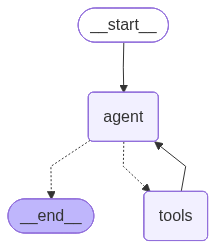

In [ ]:

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3


# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}

# Create agent using create_react_agent directly
model = init_chat_model(model="gpt-4o-mini", api_key="sk-proj-***", temperature=0.0)

# Tools for sub-agent
sub_agent_tools = [web_search]

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

# Tools
delegation_tools = [task_tool]

# Create agent with system prompt
agent = create_react_agent(
    model,
    delegation_tools,
    prompt=SUBAGENT_USAGE_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    ),
    state_schema=DeepAgentState,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [11]:

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

result["messages"]

[HumanMessage(content='Give me an overview of Model Context Protocol (MCP).', additional_kwargs={}, response_metadata={}, id='14a801b6-a940-4d8a-9fd9-26150a0ad8db'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3akegPLVPbxbOcShOR3GtWTp', 'function': {'arguments': '{"description":"Provide an overview of the Model Context Protocol (MCP), including its purpose, key features, and applications.","subagent_type":"research-agent"}', 'name': 'task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 905, 'total_tokens': 945, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CTVbHhFnCS0UYftWm3awaf1vtysvk', 'service_tier': 'default', 'finish_reason': 'tool_ca

#### Pretty print a conversation flow from an agent system.

In [ ]:
def pretty_print_conversation(conversation_data):
    print("=" * 80)
    print("🤖 AGENT CONVERSATION FLOW")
    print("=" * 80)
    
    for i, message in enumerate(conversation_data):
        print(f"\n📝 Step {i + 1}: {type(message).__name__}")
        print("-" * 50)
        
        if hasattr(message, 'content') and message.content:
            print(f"💬 Content: {message.content}")
        
        # Handle tool calls
        if hasattr(message, 'tool_calls') and message.tool_calls:
            print("🔧 Tool Calls:")
            for tool_call in message.tool_calls:
                print(f"   • Tool: {tool_call.get('name', 'Unknown')}")
                if 'args' in tool_call:
                    args = tool_call['args']
                    print(f"     - Description: {args.get('description', 'N/A')}")
                    print(f"     - Subagent Type: {args.get('subagent_type', 'N/A')}")
        
        # Handle additional metadata
        if hasattr(message, 'additional_kwargs') and message.additional_kwargs:
            if 'tool_calls' in message.additional_kwargs:
                print("🔧 Additional Tool Calls:")
                for tool_call in message.additional_kwargs['tool_calls']:
                    print(f"   • {tool_call.get('function', {}).get('name', 'Unknown')}")
        
        # Handle response metadata
        if hasattr(message, 'response_metadata') and message.response_metadata:
            metadata = message.response_metadata
            if 'token_usage' in metadata:
                usage = metadata['token_usage']
                print(f"📊 Token Usage: {usage.get('total_tokens', 0)} total")
                print(f"   - Input: {usage.get('prompt_tokens', 0)}")
                print(f"   - Output: {usage.get('completion_tokens', 0)}")
        
        # Handle usage metadata
        if hasattr(message, 'usage_metadata') and message.usage_metadata:
            usage = message.usage_metadata
            print(f"📊 Usage: {usage.get('total_tokens', 0)} total tokens")
        
        print()
    
    print("=" * 80)
    print("✅ Conversation Complete")
    print("=" * 80)



# Run the pretty print function
pretty_print_conversation(result["messages"])


🤖 AGENT CONVERSATION FLOW

📝 Step 1: HumanMessage
--------------------------------------------------
💬 Content: Give me an overview of Model Context Protocol (MCP).


📝 Step 2: AIMessage
--------------------------------------------------
🔧 Tool Calls:
   • Tool: task
     - Description: Provide an overview of the Model Context Protocol (MCP), including its purpose, key features, and applications.
     - Subagent Type: research-agent
🔧 Additional Tool Calls:
   • task
📊 Token Usage: 945 total
   - Input: 905
   - Output: 40
📊 Usage: 945 total tokens


📝 Step 3: ToolMessage
--------------------------------------------------
💬 Content: The Model Context Protocol (MCP) is an open standard developed by Anthropic designed to facilitate the integration of AI models with external systems, such as tools, databases, and services. Its primary purpose is to create a standardized communication layer that allows AI models to access and utilize data from diverse sources efficiently. By providing a un

---

### Step-by-Step: What Happens At Runtime

**1. User asks the supervisor:**
   - “Give me an overview of Model Context Protocol (MCP).”

**2. Supervisor decides:** “This is research; I’ll delegate.”
   - Calls `task(...)` with:
     - `description`: a well-scoped research instruction
     - `subagent_type`: `"research-agent"`

**3. The `task` tool:**
   - Validates the sub-agent exists
   - Sets isolated context: only the `description` message
   - Runs the sub-agent

**4. The sub-agent:**
   - Has its own prompt (SIMPLE_RESEARCH_INSTRUCTIONS)
   - Has only `web_search` as a tool
   - Makes a single `web_search` call (per instructions)
   - Produces a final answer

**5. The `task` tool:**
   - Returns a `Command` that:
     - Merges any file changes
     - Converts the sub-agent’s final message to a `ToolMessage` for the supervisor

**6. The supervisor:**
   - Receives the tool output and returns the final answer to the user (often mirroring or refining the sub-agent’s result).

Result: You keep the parent conversation clean, avoid context clash, and achieve focused task execution.

---

### Why This Pattern Is Powerful

- Isolation by design
  - Each sub-agent gets only what it needs: a task description + limited tools
- Safer, clearer reasoning
  - No accidental interference from unrelated prior messages
- Scales with complexity
  - Multiple sub-agents can run in parallel for orthogonal subtasks
- Composable
  - Add more sub-agents (e.g., “summarizer-agent”, “code-agent”, “planner-agent”) by adding entries to the config list and giving them tool subsets and prompts
